In [46]:
import pandas as pd

import numpy as np
from scipy.stats import gaussian_kde

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_excel('7001已改列名.xlsx')

In [3]:
#强制转换成数字，这样可以把其中的字符串转为NaN
df['希望有几个孩子'] = pd.to_numeric(df['希望有几个孩子'], errors='coerce')
df['所住房屋面积'] = pd.to_numeric(df['所住房屋面积'], errors='coerce')
df['个人2020年收入'] = pd.to_numeric(df['个人2020年收入'], errors='coerce')
df['2020家庭年收入'] = pd.to_numeric(df['2020家庭年收入'], errors='coerce')

In [4]:
#生育意愿指标修改，大于一个孩子为高意愿，小于等于一个为低意愿
df.loc[df['希望有几个孩子'] <= 1, '希望有几个孩子'] = 0
df.loc[df['希望有几个孩子'] > 1, '希望有几个孩子'] = 1

In [5]:
df.rename(columns={'希望有几个孩子':'Fertility_Willingness',
                  '最高教育程度':'Education',
                   '所住房屋面积':'House_Area',
                   '个人2020年收入':'Personal_Income',
                   '房价指数':'House_Price',
                   '出生年份':'Year_of_Birth'},inplace=True)

In [6]:
df = df.dropna(subset=['Fertility_Willingness','Education','House_Area','Personal_Income','House_Price','Year_of_Birth'])

In [7]:
import math

df['Personal_Income_log']=np.log10(df['Personal_Income']+1)#避免log0
df['Personal_Income_log']

0       4.778158
1       4.698979
2       4.556315
4       5.113947
5       5.301032
          ...   
8135    4.000043
8137    0.000000
8141    4.875067
8142    4.477136
8145    4.623260
Name: Personal_Income_log, Length: 6383, dtype: float64

In [8]:
df.loc[df['Year_of_Birth'] < 1985, 'age'] = 'Old'
df.loc[df['Year_of_Birth'] >= 1985, 'age'] = 'Young'

In [9]:
df.loc[:,'Age'] = 2020 - df['Year_of_Birth']


In [10]:
df['Age']

0       35
1       63
2       59
4       52
5       48
        ..
8135    17
8137    19
8141    32
8142    44
8145    42
Name: Age, Length: 6383, dtype: int64

In [11]:
import matplotlib.pyplot as plt

In [12]:
df['Fertility_Willingness']

0       1.0
1       0.0
2       0.0
4       0.0
5       0.0
       ... 
8135    1.0
8137    1.0
8141    0.0
8142    1.0
8145    1.0
Name: Fertility_Willingness, Length: 6383, dtype: float64

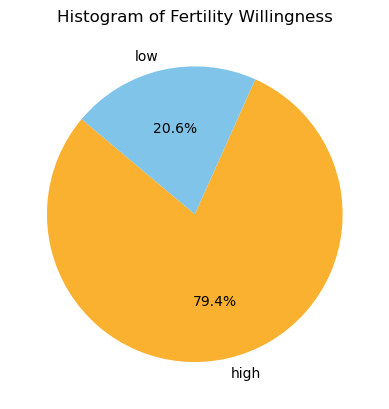

In [23]:
df1 = df.dropna(subset=['Fertility_Willingness'])
high = (df[df['Fertility_Willingness'] == 1]).shape[0]
low = (df[df['Fertility_Willingness'] == 0]).shape[0]


# 准备饼图的数据
sizes = [high,low]

labels = ['high', 'low']
colors = ['#FAB12F','#80C4E9']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Histogram of Fertility Willingness')
plt.show()

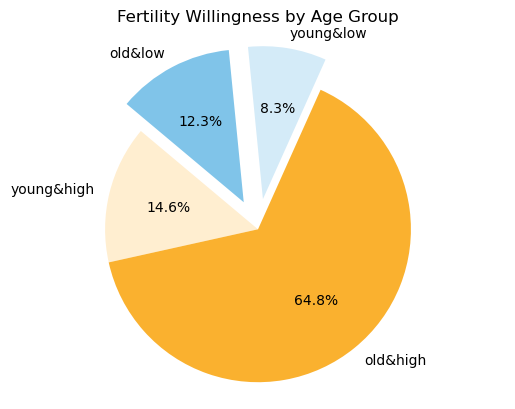

In [24]:
age_group_0_high = (df[(df['Year_of_Birth'] >= 1985) & (df['Fertility_Willingness'] == 1)]).shape[0]
age_group_0_low = (df[(df['Year_of_Birth'] >= 1985) & (df['Fertility_Willingness'] == 0)]).shape[0]
age_group_1_high = (df[(df['Year_of_Birth'] < 1985) & (df['Fertility_Willingness'] == 1)]).shape[0]
age_group_1_low = (df[(df['Year_of_Birth'] < 1985) & (df['Fertility_Willingness'] == 0)]).shape[0]

# 准备饼图的数据
sizes = [age_group_0_high, age_group_1_high, age_group_0_low, age_group_1_low]
labels = ['young&high', 'old&high', 'young&low', 'old&low']
colors = ['#FFEED0','#FAB12F','#D4EBF8','#80C4E9']  # 为每个部分指定颜色
explode = (0, 0, 0.2, 0.2)
# 绘制饼图
plt.pie(sizes, explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)


# 等比例显示饼图
plt.axis('equal')

# 显示图表
plt.title('Fertility Willingness by Age Group')

# 显示图表
plt.show()

In [19]:
import seaborn as sns

In [25]:
df = df[df['Personal_Income'] < 2000000]


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 假设df是包含自变量的DataFrame
X = df[['Education', 'House_Area', 'Personal_Income', 'House_Price','Age']]  # 选择自变量列

# 计算每个自变量的VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

           feature       VIF
0        Education  3.981284
1       House_Area  2.412035
2  Personal_Income  1.627750
3      House_Price  2.624098
4              Age  3.822149


In [27]:
from linearmodels.iv import IV2SLS
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.gmm import IV2SLS
                 

# 假设'y'是被解释变量，'X'是外生变量，'Z'是内生变量，'W'是工具变量
model = IV2SLS.from_formula('Fertility_Willingness ~ Personal_Income + Education|House_Area', data=df)
  # 添加工具变量
results = model.fit()
print(results)

PatsyError: Error evaluating factor: TypeError: unsupported operand type(s) for |: 'float' and 'float'
    Fertility_Willingness ~ Personal_Income + Education|House_Area
                                              ^^^^^^^^^^^^^^^^^^^^

NameError: name 'install' is not defined

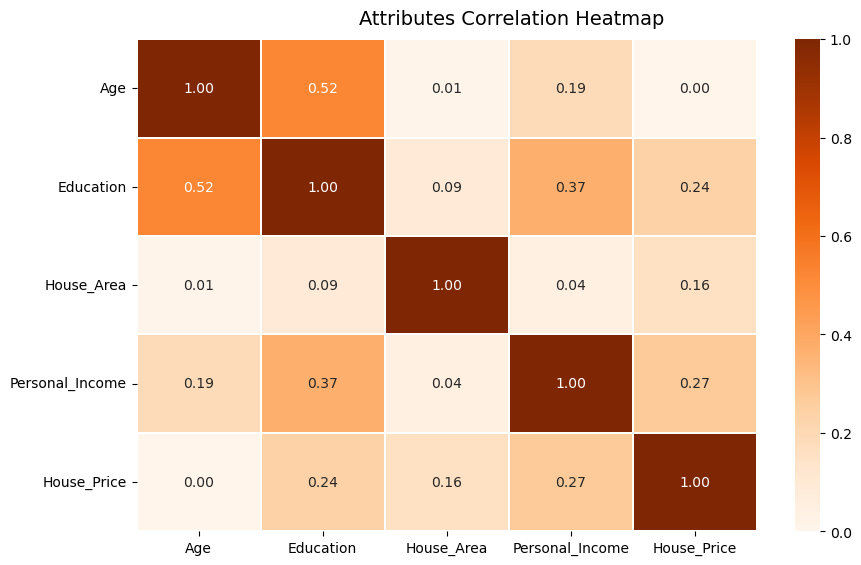

In [28]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = df[['Age','Education', 'House_Area', 'Personal_Income', 'House_Price']].corr()
hm = sns.heatmap(abs(round(corr,2)), annot=True, ax=ax, cmap="Oranges",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Attributes Correlation Heatmap', fontsize=14)

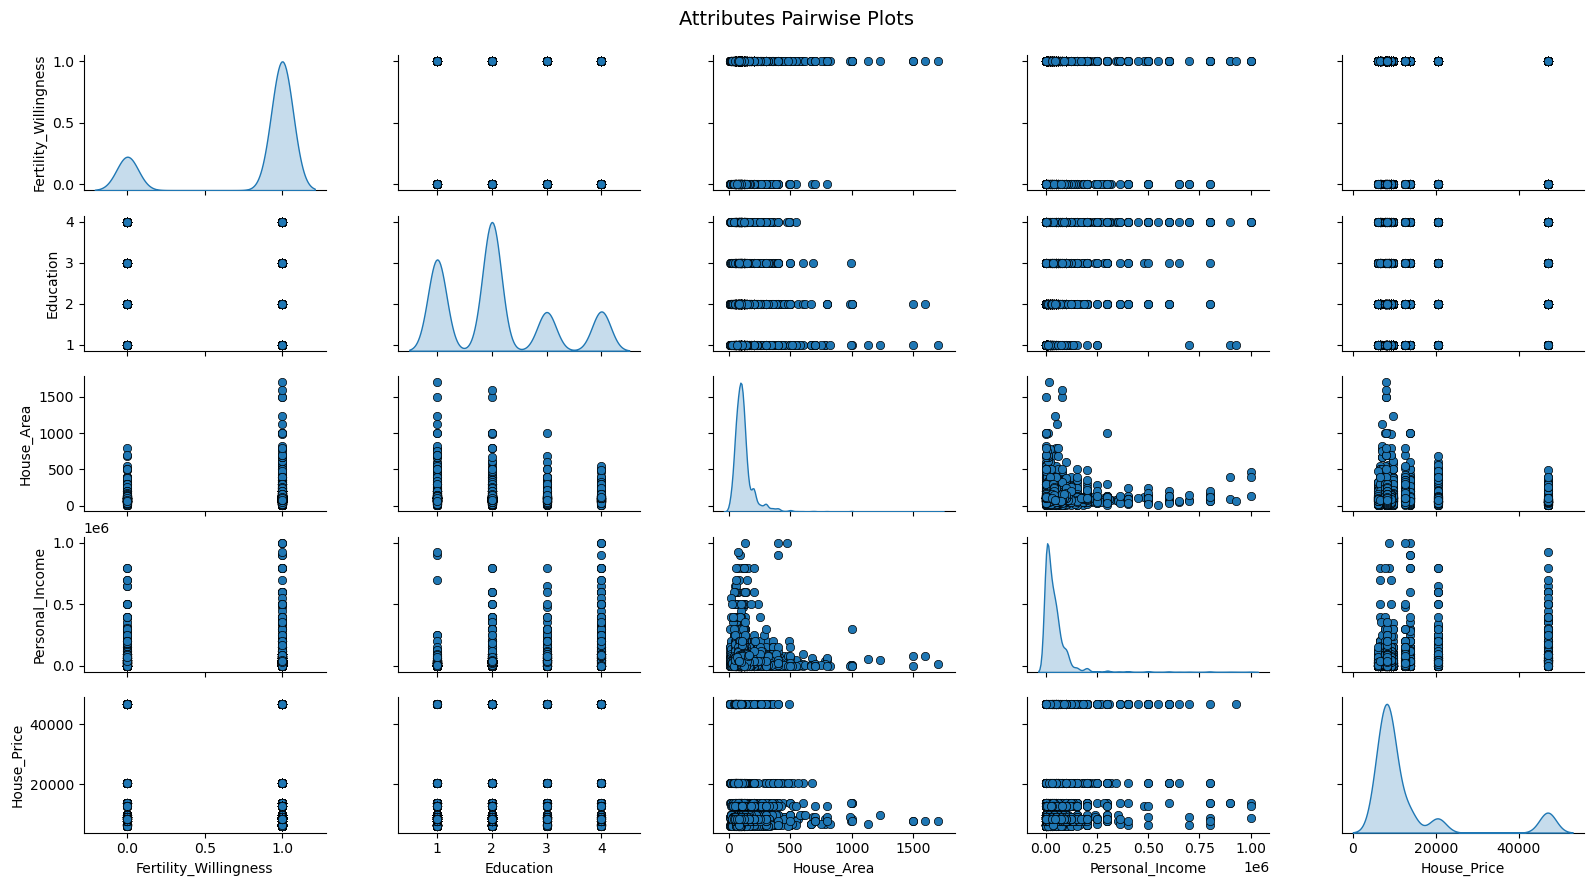

In [29]:
# Pair-wise Scatter Plots
cols = ['Fertility_Willingness','Education', 'House_Area', 'Personal_Income', 'House_Price']
pp = sns.pairplot(df[cols], height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(fill=True))

# 获取图形对象
fig = pp.fig

# 自定义标题
fig.suptitle('Attributes Pairwise Plots', fontsize=14)

# 调整子图间距
fig.subplots_adjust(top=0.93, wspace=0.3)

# 显示图形
plt.show()

In [32]:
df['Fertility_Willingness_str']=df['Fertility_Willingness'].astype(str)
df.loc[df['Fertility_Willingness_str'] == '1.0', 'Fertility_Willingness_str'] = 'high'
df.loc[df['Fertility_Willingness_str'] == '0.0', 'Fertility_Willingness_str'] = 'low'

In [33]:
df['Fertility_Willingness_str'].describe()

count     6375
unique       2
top       high
freq      5062
Name: Fertility_Willingness_str, dtype: object

<Figure size 600x400 with 0 Axes>

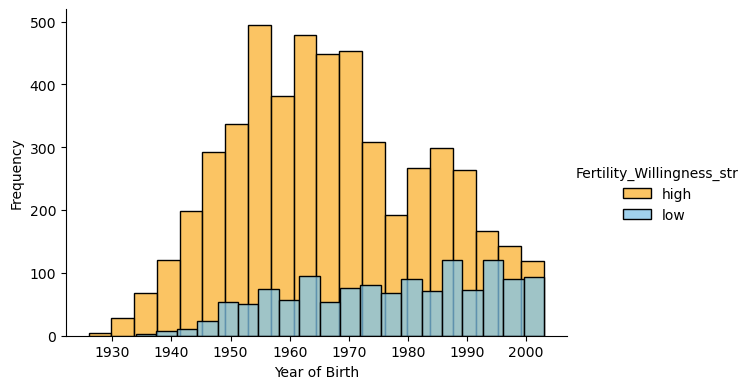

In [34]:
fig = plt.figure(figsize=(6, 4))
title = fig.suptitle("Fertility_Willingness in age", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

# 创建一个FacetGrid对象，FacetGrid会自动创建子图
g = sns.FacetGrid(df, hue='Fertility_Willingness_str', palette={'high': "#FAB12F", 'low': "#80C4E9"}, height=4, aspect=1.5)

# 映射histplot到FacetGrid对象
g.map(sns.histplot, 'Year_of_Birth', kde=False, bins=20)

# 添加图例
g.add_legend()

# 设置轴标签
g.set_xlabels("Year of Birth")
g.set_ylabels("Frequency")

# 显示图形
plt.show()


Text(0, 0.5, 'Personal Income')

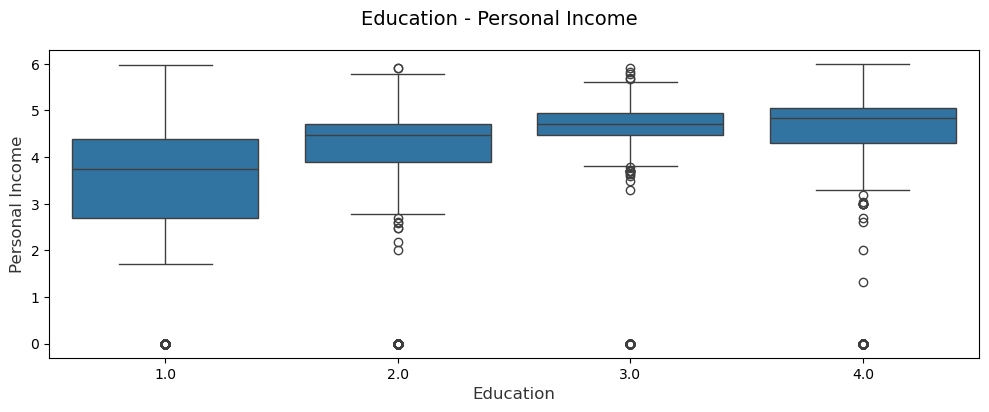

In [35]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Education - Personal Income', fontsize=14)

sns.boxplot(x="Education", y="Personal_Income_log", data=df,  ax=ax)
ax.set_xlabel("Education",size = 12,alpha=0.8)
ax.set_ylabel("Personal Income",size = 12,alpha=0.8)

In [36]:
young = df[df['age'] == 'Young']
old = df[df['age'] == 'Old']

<Axes: xlabel='Personal_Income_log', ylabel='House_Area'>

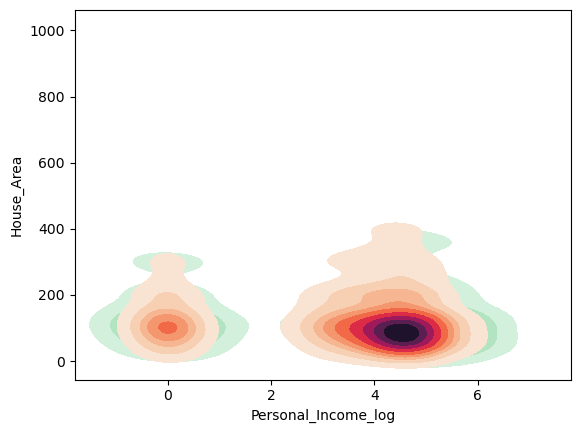

In [27]:
'''
fig, ax = plt.subplots()

# 绘制分组的核密度估计图

sns.kdeplot(x=young['Personal_Income_log'], y=young['House_Area'],
           cmap="mako_r", fill=True, ax=ax)

sns.kdeplot(x=old['Personal_Income_log'], y=old['House_Area'],
           cmap="rocket_r", fill=True, ax=ax)
'''

<Axes: xlabel='Personal_Income_log', ylabel='Education'>

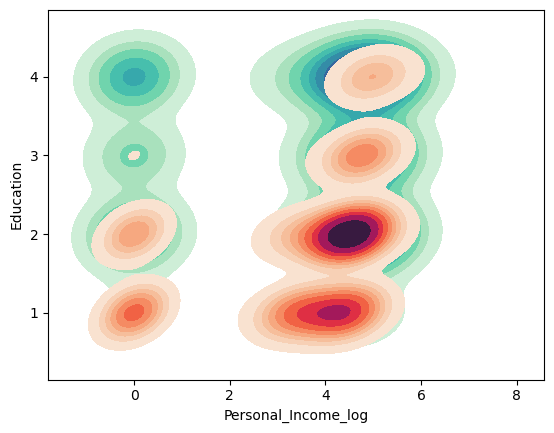

In [59]:
'''
fig, ax = plt.subplots()

# 绘制分组的核密度估计图

sns.kdeplot(x=young['Personal_Income_log'], y=young['Education'],
           cmap="mako_r", fill=True, ax=ax)

sns.kdeplot(x=old['Personal_Income_log'], y=old['Education'],
           cmap="rocket_r", fill=True, ax=ax)
           '''

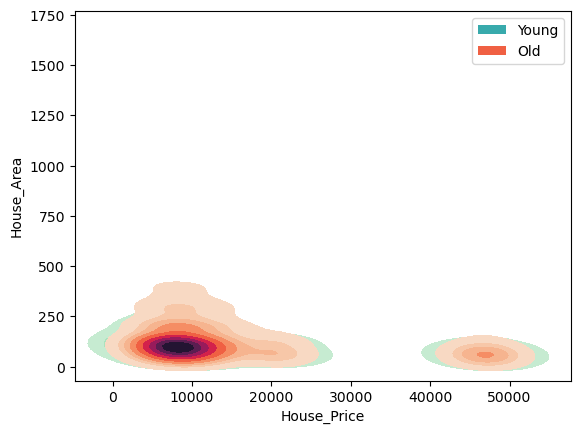

In [105]:
'''
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()

cmap1=ListedColormap(sns.color_palette("mako_r", n_colors=20))
cmap2=ListedColormap(sns.color_palette("rocket_r", n_colors=20))

# 绘制核密度图
sns.kdeplot(x=young['House_Price'], y=young['House_Area'],
            cmap=cmap1, fill=True, ax=ax)
sns.kdeplot(x=old['House_Price'], y=old['House_Area'],
            cmap=cmap2, fill=True, ax=ax)


# 添加图例
legend_handle = [Patch(facecolor=cmap1(0.3), label='Young', edgecolor='none'),
                Patch(facecolor=cmap2(0.3), label='Old', edgecolor='none')]  # 使用渐变色的中间值

# 添加图例
ax.legend(handles=legend_handle, loc='best')

# 显示图形
plt.show()
'''

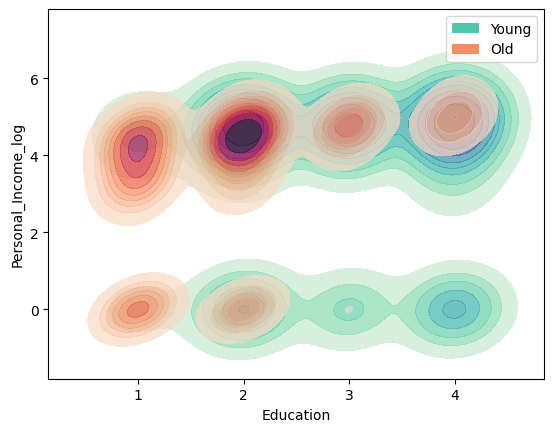

In [37]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()

cmap1=ListedColormap(sns.color_palette("mako_r", n_colors=20))
cmap2=ListedColormap(sns.color_palette("rocket_r", n_colors=20))

# 绘制核密度图
sns.kdeplot(y=young['Personal_Income_log'], x=young['Education'],
            cmap=cmap1, alpha=0.7, fill=True, ax=ax)
sns.kdeplot(y=old['Personal_Income_log'], x=old['Education'],
            cmap=cmap2, alpha=0.7, fill=True, ax=ax)


# 添加图例
legend_handle = [Patch(facecolor=cmap1(0.2), label='Young', edgecolor='none'),
                Patch(facecolor=cmap2(0.2), label='Old', edgecolor='none')]  # 使用渐变色的中间值

# 添加图例
ax.legend(handles=legend_handle, loc='best')

# 显示图形
plt.show()

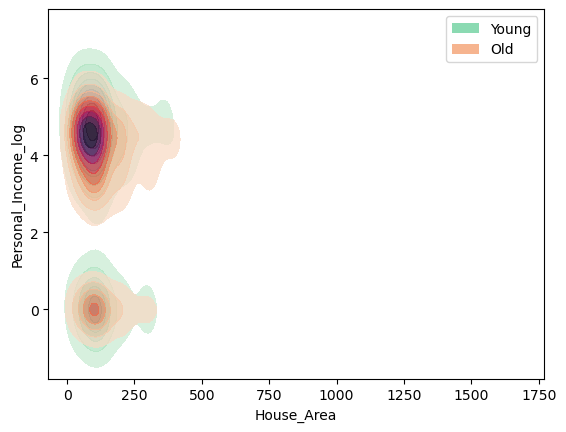

In [24]:
fig, ax = plt.subplots()

cmap1=ListedColormap(sns.color_palette("mako_r", n_colors=20))
cmap2=ListedColormap(sns.color_palette("rocket_r", n_colors=20))

# 绘制核密度图
sns.kdeplot(y=young['Personal_Income_log'], x=young['House_Area'],
            cmap=cmap1, alpha=0.7, fill=True, ax=ax)
sns.kdeplot(y=old['Personal_Income_log'], x=old['House_Area'],
            cmap=cmap2, alpha=0.7, fill=True, ax=ax)


# 添加图例
legend_handle = [Patch(facecolor=cmap1(0.1), label='Young', edgecolor='none'),
                Patch(facecolor=cmap2(0.1), label='Old', edgecolor='none')]  # 使用渐变色的中间值

# 添加图例
ax.legend(handles=legend_handle, loc='best')

# 显示图形
plt.show()

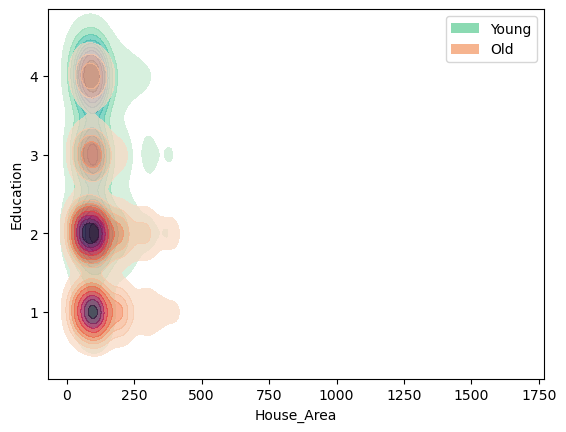

In [38]:
fig, ax = plt.subplots()

cmap1=ListedColormap(sns.color_palette("mako_r", n_colors=20))
cmap2=ListedColormap(sns.color_palette("rocket_r", n_colors=20))

# 绘制核密度图
sns.kdeplot(y=young['Education'], x=young['House_Area'],
            cmap=cmap1, alpha=0.7, fill=True, ax=ax)
sns.kdeplot(y=old['Education'], x=old['House_Area'],
            cmap=cmap2, alpha=0.7, fill=True, ax=ax)


# 添加图例
legend_handle = [Patch(facecolor=cmap1(0.1), label='Young', edgecolor='none'),
                Patch(facecolor=cmap2(0.1), label='Old', edgecolor='none')]  # 使用渐变色的中间值

# 添加图例
ax.legend(handles=legend_handle, loc='best')

# 显示图形
plt.show()

In [18]:
corr = df[['Education', 'Year_of_Birth','House_Area', 'Personal_Income_log', 'House_Price']].corr()
corr

,Education,Year_of_Birth,House_Area,Personal_Income_log,House_Price
Education,1.000000,0.515770,-0.093902,0.220847,0.235555
Year_of_Birth,0.515770,1.000000,-0.008232,0.022337,0.005132
House_Area,-0.093902,-0.008232,1.000000,-0.089083,-0.156710
Personal_Income_log,0.220847,0.022337,-0.089083,1.000000,0.174750
House_Price,0.235555,0.005132,-0.156710,0.174750,1.000000


In [ ]:


# 生成一些随机数据
np.random.seed(0)
x = np.random.normal(size=1000)
y = np.random.normal(size=1000)
z = np.random.normal(size=1000)

# 计算核密度估计
values = np.vstack([x, y, z])
kernel = gaussian_kde(values)

# 创建图形和轴对象
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 定义绘制范围
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
zmin, zmax = z.min(), z.max()
X, Y, Z = np.mgrid[xmin:xmax:100j, ymin:ymax:100j, zmin:zmax:100j]

# 计算网格点上的核密度值
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
density = np.reshape(kernel(positions).T, X.shape)

# 绘制等值面（isosurface）来表示核密度
ax.contourf(X, Y, Z, density, levels=15, cmap='viridis', offset=zmin)

# 可以添加一些散点图来表示原始数据点
ax.scatter(x, y, z, color='r', s=1)

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.colorbar(contour)
plt.show()

Text(0.5, 0, 'Income')

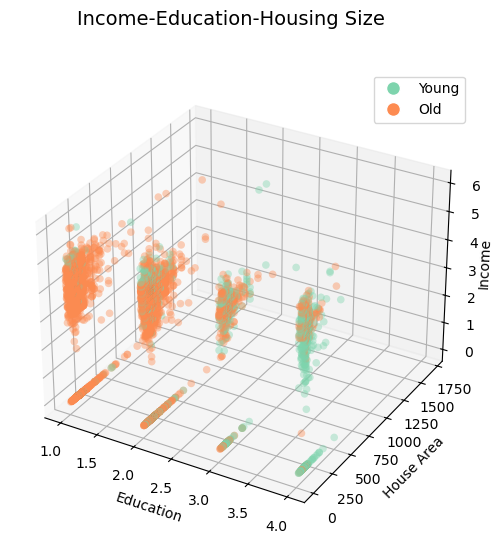

In [54]:
from matplotlib.lines import Line2D

# Visualizing 4-D mix data using scatter plots
# leveraging the concepts of hue and depth
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('Income-Education-Housing Size', fontsize=14)
ax = fig.add_subplot(111, projection='3d')


xs = df['Education'].tolist()
ys = df['House_Area'].tolist()
zs = df['Personal_Income_log'].tolist()
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['#FD8B51' if wt == 'Old' else '#7ED4AD' for wt in df['age'].tolist()]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Young', markerfacecolor='#7ED4AD', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Old', markerfacecolor='#FD8B51', markersize=10)]


# 添加图例
ax.legend(handles=legend_elements, loc='best')

ax.set_xlabel('Education')
ax.set_ylabel('House Area')
ax.set_zlabel('Income',labelpad=-4)

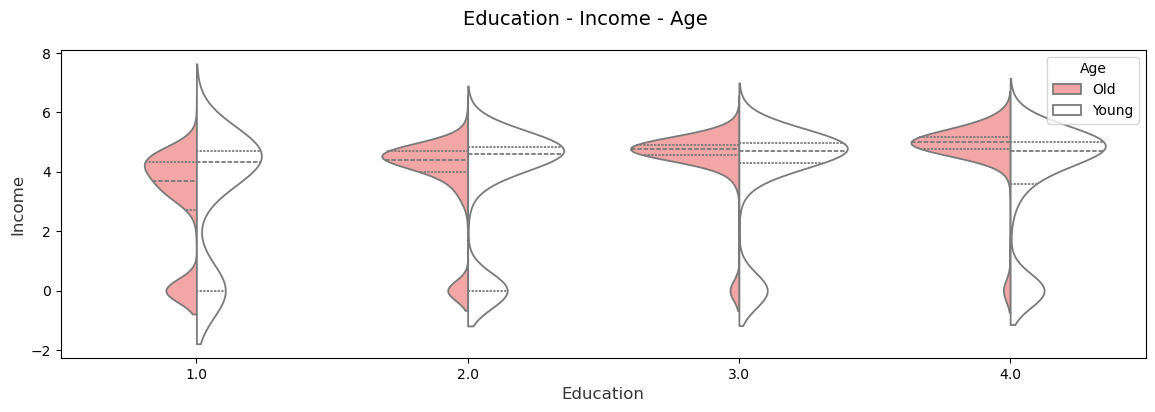

In [47]:
# Visualizing 3-D mix data using violin plots
# leveraging the concepts of hue and axes for > 1 categorical dimensions
f,  ax2 = plt.subplots(1, 1, figsize=(14, 4))

f.suptitle('Education - Income - Age', fontsize=14)


sns.violinplot(x="Education", y='Personal_Income_log', hue="age", 
               data=df, split=True, inner="quart", linewidth=1.3,
               palette={"Old": "#FF9999", "Young": "white"}, ax=ax2)
ax2.set_xlabel('Education',size = 12,alpha=0.8)
ax2.set_ylabel("Income",size = 12,alpha=0.8)
l = plt.legend(loc='upper right', title='Age')

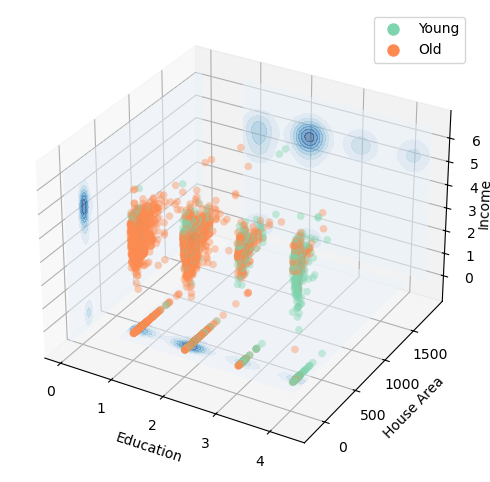

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd

# 假设df是包含数据的DataFrame
# df = pd.DataFrame({
#     'Education': np.random.rand(100),
#     'House_Area': np.random.rand(100),
#     'Personal_Income_log': np.random.rand(100),
#     'age': np.random.choice(['Young', 'Old'], 100)
# })

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 提取数据
xs = df['Education'].values
ys = df['House_Area'].values
zs = df['Personal_Income_log'].values

# 绘制3D散点图
colors = ['#FD8B51' if wt == 'Old' else '#7ED4AD' for wt in df['age'].tolist()]
ax.scatter(xs, ys, zs, alpha=0.4, c=colors, edgecolors='none', s=30)

# 添加图例
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Young', markerfacecolor='#7ED4AD', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Old', markerfacecolor='#FD8B51', markersize=10)]
ax.legend(handles=legend_elements, loc='best')

# 设置轴标签
ax.set_xlabel('Education')
ax.set_ylabel('House Area')
ax.set_zlabel('Income', labelpad=-4)

# 计算核密度估计
xy_kde = gaussian_kde(np.vstack([xs, ys]))
xz_kde = gaussian_kde(np.vstack([xs, zs]))
yz_kde = gaussian_kde(np.vstack([ys, zs]))

# 绘制XY平面的核密度投影
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
Z = xy_kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
ax.contourf(X, Y, Z, zdir='z', offset=-0.05, cmap="Blues", alpha=0.5)

# 绘制XZ平面的核密度投影
xmin, xmax = ax.get_xlim()
zmin, zmax = ax.get_zlim()
X, Z = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(zmin, zmax, 100))
Y = xz_kde(np.vstack([X.ravel(), Z.ravel()])).reshape(X.shape)
ax.contourf(X, Y, Z, zdir='y', offset=2000, cmap="Blues", alpha=0.5)

# 绘制YZ平面的核密度投影
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
Y, Z = np.meshgrid(np.linspace(ymin, ymax, 100), np.linspace(zmin, zmax, 100))
X = yz_kde(np.vstack([Y.ravel(), Z.ravel()])).reshape(X.shape)
ax.contourf(X, Y, Z, zdir='x', offset=0, cmap="Blues", alpha=0.5)

plt.show()